<a href="https://colab.research.google.com/github/kridtapon/SMA-ADX-Walk-Forward-Optimization/blob/main/SMA%2BADX_Walk_Forward_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstal

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Calculate moving averages
def calculate_moving_averages(df, ma_window=50):
    """Calculate moving averages."""
    df['SMA'] = df['Close'].rolling(window=ma_window).mean()
    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ])

    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low),
                         np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)),
                         np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate indicators
df = calculate_moving_averages(df, ma_window=44)
df = calculate_adx(df, period=28)

# Define entry and exit signals
adx_threshold = 22

# Filter data for test period (e.g., 2020-2025)
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df_test['Entry'] = (
    (df_test['ADX'] > adx_threshold) &  # ADX above threshold
    (df_test['Close'] > df_test['SMA'])      # Price above SMA
)

df_test['Exit'] = (
    (df_test['ADX'] > adx_threshold) &  # ADX above threshold
    (df_test['Close'] < df_test['SMA'])      # Price below SMA
)

# Convert signals to boolean arrays
entries = df_test['Entry'].to_numpy()
exits = df_test['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-45a3f84bdbf3>:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_final_profit = buy_and_hold_value[-1] - initial_cash


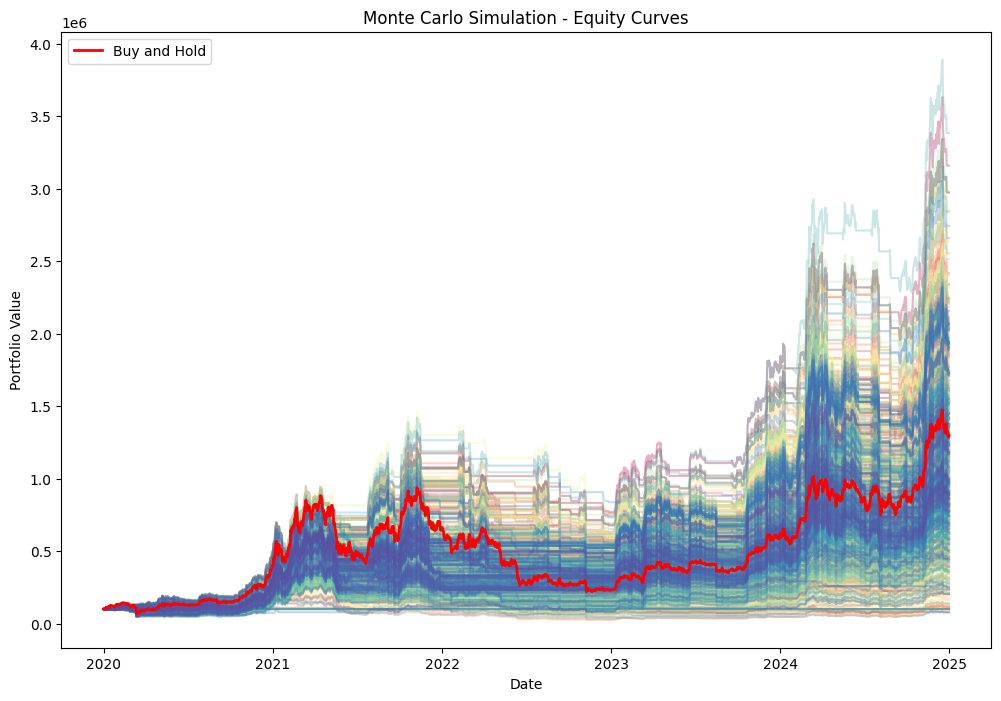

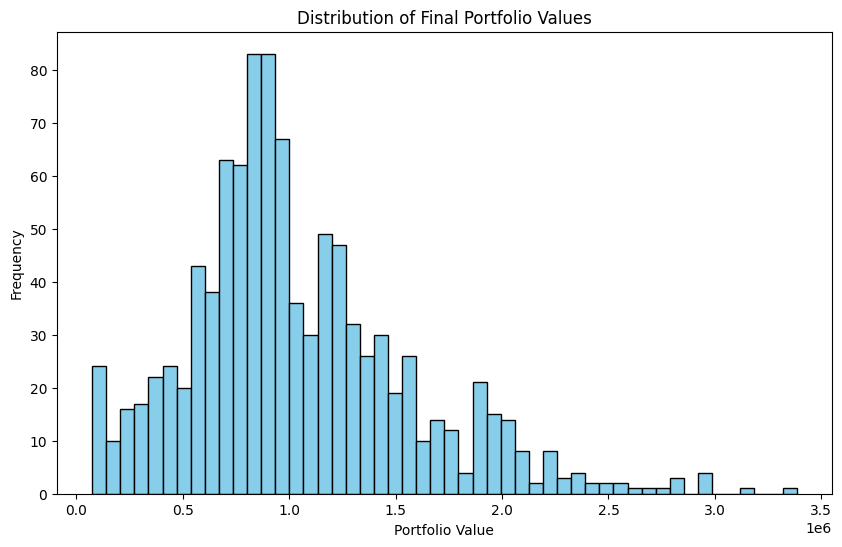

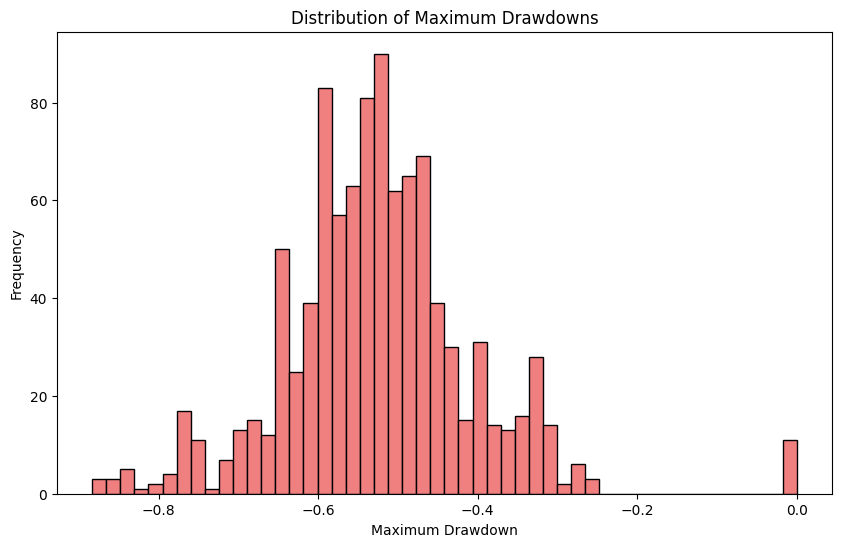

Mean Profit: 1037846.342985925
Median Profit: 924065.0330910853
Standard Deviation of Profit: 527498.65256116
Buy and Hold Final Profit: 1197596.4055774745
Mean Drawdown: -0.524860471545953
Median Drawdown: -0.5276793547149584
Standard Deviation of Drawdown: 0.12060414177934455
Buy and Hold Maximum Drawdown: -0.7663456370856908


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate SMA
def calculate_sma(df, period):
    df['SMA'] = df['Close'].rolling(window=period).mean()
    return df

# Function to calculate ADX
def calculate_adx(df, period):
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['+DI'] = (df['+DM'].rolling(window=period).mean() / df['TR_smoothed']) * 100
    df['-DI'] = (df['-DM'].rolling(window=period).mean() / df['TR_smoothed']) * 100
    df['DX'] = abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']) * 100
    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define stock and date range
symbol = 'BTC-USD'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Monte Carlo Simulation
num_simulations = 1000
initial_cash = 100_000
fees = 0.001
simulation_results = []
equity_curves = []
max_drawdowns = []

# Perform simulations
for i in range(num_simulations):
    # Randomize parameters
    adx_period = np.random.randint(1, 51)   # ADX calculation period
    sma_period = np.random.randint(1, 201)  # SMA calculation period
    adx_threshold = np.random.uniform(1, 51)  # ADX threshold

    # Calculate indicators
    df = calculate_adx(df.copy(), adx_period)
    df = calculate_sma(df.copy(), sma_period)

    # Define entry and exit signals
    df['Entry'] = (df['ADX'] > adx_threshold) & (df['Close'] > df['SMA'])
    df['Exit'] = (df['ADX'] > adx_threshold) & (df['Close'] < df['SMA'])

    # Filter data for test period (e.g., 2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest
    cash = initial_cash
    position = 0
    equity_curve = []

    # Iterate through the DataFrame indices
    for idx in range(1, len(df_test)):
        if df_test['Entry'].iloc[idx] and cash > 0:
            position = cash / df_test['Close'].iloc[idx]  # Buy full position
            cash = 0
        elif df_test['Exit'].iloc[idx] and position > 0:
            cash = position * df_test['Close'].iloc[idx]  # Sell position
            position = 0
        equity_curve.append(cash + (position * df_test['Close'].iloc[idx]))

    equity_curve = np.array(equity_curve)
    simulation_results.append(equity_curve[-1])
    equity_curves.append(equity_curve)

    # Max drawdown
    drawdowns = equity_curve / np.maximum.accumulate(equity_curve) - 1
    max_drawdowns.append(drawdowns.min())

# Filter data for test period (e.g., 2020-2025)
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Analyze results
simulation_results = np.array(simulation_results)
mean_profit = np.mean(simulation_results)
median_profit = np.median(simulation_results)
std_dev_profit = np.std(simulation_results)

# Buy-and-Hold strategy
buy_and_hold_value = initial_cash * (df_test['Close'] / df_test['Close'].iloc[0])

# Buy-and-Hold final profit
buy_and_hold_final_profit = buy_and_hold_value[-1] - initial_cash

# Calculate Buy and Hold drawdown
buy_and_hold_drawdowns = buy_and_hold_value / np.maximum.accumulate(buy_and_hold_value) - 1
max_buy_and_hold_drawdown = buy_and_hold_drawdowns.min()

# Calculate mean, median, and standard deviation of drawdowns
mean_drawdown = np.mean(max_drawdowns)
median_drawdown = np.median(max_drawdowns)
std_dev_drawdown = np.std(max_drawdowns)

# Plot results
plt.figure(figsize=(12, 8))

# Plot all equity curves
colors = sns.color_palette("Spectral", num_simulations)
for i, equity_curve in enumerate(equity_curves):
    plt.plot(df_test.index[1:], equity_curve, alpha=0.3, color=colors[i % len(colors)])

# Plot Buy-and-Hold curve
plt.plot(df_test.index, buy_and_hold_value, color='red', label='Buy and Hold', linewidth=2)

# Chart customization
plt.title('Monte Carlo Simulation - Equity Curves')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Plot histogram of profits
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=50, edgecolor='k', color='skyblue')
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of drawdowns
plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns, bins=50, edgecolor='k', color='lightcoral')
plt.title('Distribution of Maximum Drawdowns')
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')
plt.show()

# Print the results
print(f"Mean Profit: {mean_profit}")
print(f"Median Profit: {median_profit}")
print(f"Standard Deviation of Profit: {std_dev_profit}")
print(f"Buy and Hold Final Profit: {buy_and_hold_final_profit}")
print(f"Mean Drawdown: {mean_drawdown}")
print(f"Median Drawdown: {median_drawdown}")
print(f"Standard Deviation of Drawdown: {std_dev_drawdown}")
print(f"Buy and Hold Maximum Drawdown: {max_buy_and_hold_drawdown}")

[*********************100%***********************]  1 of 1 completed
<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Year 2017: Walk-Forward Optimization Return = 7.70


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2018: Walk-Forward Optimization Return = -0.39


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2019: Walk-Forward Optimization Return = 0.38


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2020: Walk-Forward Optimization Return = 0.79


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2021: Walk-Forward Optimization Return = 0.16


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2022: Walk-Forward Optimization Return = -0.38


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2023: Walk-Forward Optimization Return = 0.21


<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Year 2024: Walk-Forward Optimization Return = 0.34

Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2017   (42, 8, 30)     7.700239
1  2018    (5, 7, 28)    -0.393084
2  2019   (4, 22, 30)     0.382891
3  2020   (3, 16, 27)     0.791832
4  2021  (23, 12, 30)     0.159639
5  2022   (33, 9, 29)    -0.383771
6  2023   (2, 17, 25)     0.205598
7  2024  (41, 19, 27)     0.338969


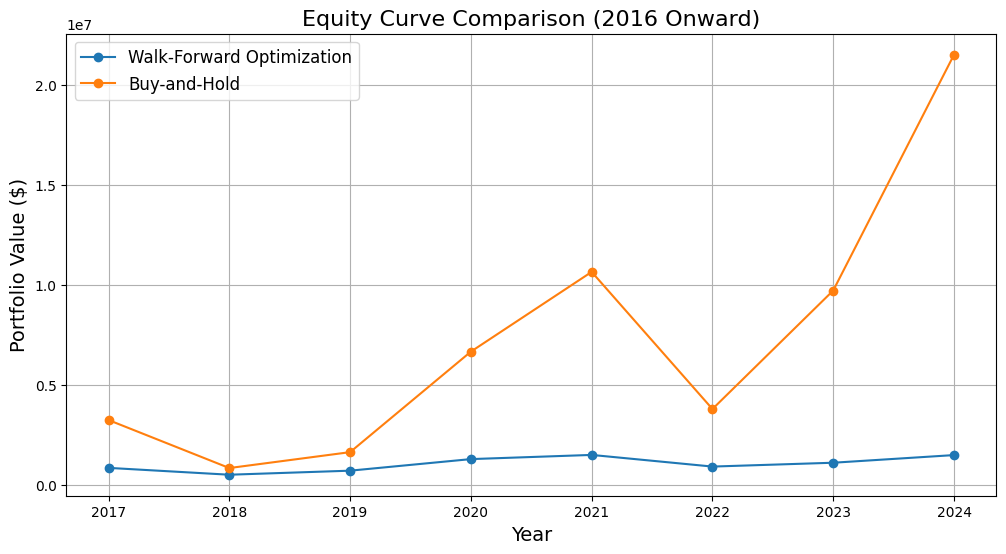

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate moving averages (SMA)
def calculate_moving_averages(df, ma_window=50):
    """Calculate moving averages."""
    df['SMA'] = df['Close'].rolling(window=ma_window).mean()
    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))])
    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Walk-forward optimization function
def walk_forward_optimization(df, start_year, end_year, ma_window_values, adx_period_values, adx_threshold_values):
    results = []

    for test_year in range(start_year + 1, end_year + 1):
        train_start = test_year - 1
        train_end = test_year - 1
        test_start = test_year
        test_end = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        for ma_window in ma_window_values:
            for adx_period in adx_period_values:
                for adx_threshold in adx_threshold_values:
                    # Calculate indicators on the training data
                    train_data = calculate_moving_averages(train_data, ma_window=ma_window)
                    train_data = calculate_adx(train_data, period=adx_period)

                    # Generate entry and exit signals
                    entries = (
                        (train_data['ADX'] > adx_threshold) &
                        (train_data['Close'] > train_data['SMA'])
                    )
                    exits = (
                        (train_data['ADX'] > adx_threshold) &
                        (train_data['Close'] < train_data['SMA'])
                    )

                    # Backtest on training data
                    portfolio = vbt.Portfolio.from_signals(
                        close=train_data['Close'],
                        entries=entries,
                        exits=exits,
                        init_cash=100_000,
                        fees=0.001
                    )

                    performance = portfolio.total_return()
                    if performance > best_performance:
                        best_performance = performance
                        best_params = (ma_window, adx_period, adx_threshold)

        # Test with the best parameters on the test data
        test_data = calculate_moving_averages(test_data, ma_window=best_params[0])
        test_data = calculate_adx(test_data, period=best_params[1])

        entries = (
            (test_data['ADX'] > best_params[2]) &
            (test_data['Close'] > test_data['SMA'])
        )
        exits = (
            (test_data['ADX'] > best_params[2]) &
            (test_data['Close'] < test_data['SMA'])
        )

        portfolio = vbt.Portfolio.from_signals(
            close=test_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

        # Print the performance for the year
        print(f"Year {test_year}: Walk-Forward Optimization Return = {portfolio.total_return():.2f}")

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameter grid for optimization
ma_window_values = range(1, 61)  # SMA window values (e.g., from 1 to 60)
adx_period_values = range(1, 31)  # ADX period values (e.g., from 1 to 30)
adx_threshold_values = range(1, 31)  # ADX threshold values (e.g., from 1 to 30)

# Perform walk-forward optimization
results = walk_forward_optimization(df, 2016, 2024, ma_window_values, adx_period_values, adx_threshold_values)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Filter data to include only from 2016 onward
results = results[results['Year'] >= 2016]
df = df[df.index.year >= 2016]

# Initialize equity and cash
initial_cash = 100_000

# Calculate cumulative equity curve based on Test_Return
results['Equity'] = (1 + results['Test_Return']).cumprod() * initial_cash

# Buy-and-Hold Strategy
buy_and_hold_initial_cash = 100_000
df['Daily_Returns'] = df['Close'].pct_change()
df['Buy_and_Hold_Equity'] = (1 + df['Daily_Returns']).cumprod() * buy_and_hold_initial_cash

# Align the buy-and-hold equity curve with the walk-forward results for comparison
buy_and_hold_equity = df.loc[df.index.year.isin(results['Year']), 'Buy_and_Hold_Equity'].resample('Y').last()
buy_and_hold_equity = buy_and_hold_equity.reset_index(drop=True)

# Comparison plot
plt.figure(figsize=(12, 6))
plt.plot(results['Year'], results['Equity'], marker='o', label='Walk-Forward Optimization')
plt.plot(results['Year'], buy_and_hold_equity.values, marker='o', label='Buy-and-Hold')
plt.title('Equity Curve Comparison (2016 Onward)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.show()


In [20]:
# Combine all years into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    ma_window, adx_period, adx_threshold = row['Best_Params']
    yearly_data = df[df.index.year == year]

    # Calculate indicators
    yearly_data = calculate_moving_averages(yearly_data, ma_window=ma_window)
    yearly_data = calculate_adx(yearly_data, period=adx_period)

    # Generate entry and exit signals
    entries = (
        (yearly_data['ADX'] > adx_threshold) &
        (yearly_data['Close'] > yearly_data['SMA'])
    )
    exits = (
        (yearly_data['ADX'] > adx_threshold) &
        (yearly_data['Close'] < yearly_data['SMA'])
    )

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Backtest the combined strategy
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

<ipython-input-19-2f1be8cd5811>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1be8cd5811>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-2f1b

Start                                2016-01-01 00:00:00
End                                  2024-12-31 00:00:00
Period                                3288 days 00:00:00
Start Value                                     100000.0
End Value                                  1351188.73893
Total Return [%]                             1251.188739
Benchmark Return [%]                         21410.91094
Max Gross Exposure [%]                             100.0
Total Fees Paid                              363492.1877
Max Drawdown [%]                               66.869686
Max Drawdown Duration                 1389 days 00:00:00
Total Trades                                         209
Total Closed Trades                                  208
Total Open Trades                                      1
Open Trade PnL                             447194.329521
Win Rate [%]                                   29.326923
Best Trade [%]                                198.128001
Worst Trade [%]                